In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import h5py
from nilearn.signal import clean
import collections
import random
from sklearn.model_selection import StratifiedKFold

In [3]:
def load_phenotypes(pheno_path):
    pheno = pd.read_csv(pheno_path, encoding = "ISO-8859-1")

    pheno['DX_GROUP'] = pheno['DX_GROUP'].apply(lambda v: int(v)-1)
    pheno['SITE_ID'] = pheno['SITE_ID'].apply(lambda v: re.sub('_[0-9]', '', v))
    pheno['SEX'] = pheno['SEX'].apply(lambda v: {1: "M", 2: "F"}[v])
#     pheno['MEAN_FD'] = pheno['func_mean_fd']
#     pheno['SUB_IN_SMP'] = pheno['SUB_IN_SMP'].apply(lambda v: v == 1)
#     pheno["STRAT"] = pheno[["SITE_ID", "DX_GROUP"]].apply(lambda x: "_".join([str(s) for s in x]), axis=1)

#     pheno.index = pheno['FILE_ID']
    # return pheno[['FILE_ID', 'DX_GROUP', 'SEX', 'SITE_ID', 'MEAN_FD', 'SUB_IN_SMP', 'STRAT']]
#     return pheno[['FILE_ID', 'DX_GROUP', 'SITE_ID']]
    return pheno[['SUB_ID', 'DX_GROUP', 'SITE_ID']]

In [4]:
TR = {'CALTECH':2, 'CMU':2, 'KKI':2.5, 'LEUVEN':1.67, 'MAX_MUN':3, 'NYU':2, 
      'OHSU':2.5, 'OLIN':1.5, 'PITT':1.5, 'SBL':2.2, 'SDSU':2, 'STANFORD':2, 
     'TRINITY':2, 'UCLA':3, 'UM':2, 'USM':2, 'YALE':2}

In [5]:
root = '/home/lbwang/abide_dataset_download/data/raw/ABIDE_I/all_rest/'
subjs = np.loadtxt(root+'ids.good', dtype=str)
subjs.sort()
subjs_site = []
# assert len(subjs) == len([f for f in os.listdir(root) if '.afni' in f])
file_path = '/home/lbwang/abide_dataset_download/data/raw/ABIDE_I/all_rest/%s.rest.afni/errts.fanaticor2std3.cc200.timeseries'

pheno_path = '/home/lbwang/abide_dataset_download/data/Phenotypic_ABIDE_I.csv'
pheno = load_phenotypes(pheno_path)
tmp_id = pheno['SUB_ID'].tolist()
tmp_label = pheno['DX_GROUP'].tolist()
tmp_site = pheno['SITE_ID'].tolist()
assert len(tmp_id) == len(tmp_label)
assert len(tmp_id) == len(tmp_site)
dic = collections.defaultdict(dict)
for i, sub in enumerate(tmp_id):
    dic[str(sub)]['site'] = tmp_site[i]
    dic[str(sub)]['label'] = tmp_label[i]

for sub in subjs:
    subjs_site.append(dic[str(sub)[2:]]['site'])
    
    
pheno_subj_id = pheno['SUB_ID'].tolist()
print('total subjects:', len(pheno_subj_id))
pheno_label = np.array(pheno['DX_GROUP'])
assert len(pheno_subj_id) == len(pheno_label)
print('available subjects:', len(subjs))

sites = list(set(pheno['SITE_ID'].tolist()))

total subjects: 1112
available subjects: 1057


In [8]:
dataset_name = 'abide_I_leave_one_site_out_self_preprocessing_CC200_filter_0.1_0.01_norm_demean.h5'

In [6]:
frames = 315

FC = np.zeros((len(subjs), 200, 200))
raw_data = np.zeros((len(subjs), frames, 200))

length = {}
label = []
for i, sub in enumerate(subjs):
    print(i, ':', sub)
    tmp = np.loadtxt(file_path%sub)
    length[sub] = tmp.shape[0]
    tmp_len = min(tmp.shape[0], frames)
    
# #     preprocess
# #     tmp_frame = min(frames, tmp.shape[0])
# #     tmp = tmp[:tmp_frame, :]
#     np.nan_to_num(tmp, copy=False, nan=0.0, posinf=0, neginf=0)
#     assert np.sum(np.isnan(tmp)) == 0
    
#     tmp_mean = np.mean(tmp, axis=0, keepdims=True)
#     assert tmp_mean.shape == (1, 200)
#     tmp_std = np.std(tmp, axis=0, keepdims=True)
#     assert tmp_std.shape == (1, 200)
#     tmp_std[tmp_std==0] = np.inf
#     assert np.sum(np.isnan(tmp)) == 0
#     tmp_preprocessing = (tmp - tmp_mean) / tmp_std
#     raw_data[i, :tmp_len, :] = tmp_preprocessing
    
# #     tmp_mean = np.mean(tmp, axis=1, keepdims=True)
# #     tmp_std = np.std(tmp, axis=1, keepdims=True)
# #     tmp_std[tmp_std==0]=1e-10
# #     raw_data[i, :tmp.shape[0], :] = (tmp-tmp_mean)/tmp_std
    
# nilearn  
    tmp_filter = clean(tmp, sessions=None, detrend=False, standardize=True, 
          confounds=None, low_pass=0.1, high_pass=0.01, t_r=TR[dic[sub[2:]]['site']], 
          ensure_finite=True)
#     tmp_filter = clean(tmp, sessions=None, detrend=False, standardize=True, 
#           confounds=None, low_pass=None, high_pass=None, t_r=None, 
#           ensure_finite=True)
    tmp_mean = np.mean(tmp_filter, axis=0, keepdims=True)
    assert tmp_mean.shape == (1, 200)
    tmp_filter_demean = tmp_filter - tmp_mean
    raw_data[i, :tmp_len, :] = tmp_filter_demean[:tmp_len]
    
    FC[i] = np.corrcoef(tmp_filter_demean.T)
#     assert np.sum(np.isnan(FC[i])) == 0
    FC[i, np.isnan(FC[i])] = 0
    assert np.sum(np.isnan(FC[i])) == 0
    label.append(dic[sub[2:]]['label'])
    
label = np.array(label)
assert label.shape[0] == raw_data.shape[0]

print('total subjects:', len(subjs))
print('No. of label 0:', np.sum(label == 0))
print('No. of label 1:', np.sum(label == 1))
assert np.sum(label == 0) + np.sum(label == 1) == label.shape[0]    

0 : 0050002
1 : 0050004
2 : 0050005
3 : 0050006
4 : 0050007
5 : 0050008
6 : 0050009
7 : 0050010
8 : 0050011
9 : 0050012
10 : 0050013
11 : 0050014
12 : 0050015
13 : 0050016
14 : 0050017
15 : 0050019
16 : 0050020
17 : 0050022
18 : 0050023
19 : 0050024
20 : 0050025
21 : 0050026
22 : 0050027
23 : 0050028
24 : 0050029
25 : 0050030
26 : 0050031
27 : 0050032
28 : 0050033
29 : 0050034
30 : 0050035
31 : 0050036
32 : 0050037
33 : 0050038
34 : 0050039
35 : 0050040
36 : 0050041
37 : 0050042
38 : 0050043
39 : 0050044
40 : 0050045
41 : 0050046
42 : 0050047
43 : 0050048
44 : 0050049
45 : 0050050
46 : 0050051
47 : 0050052
48 : 0050053
49 : 0050054
50 : 0050055
51 : 0050056
52 : 0050057
53 : 0050058
54 : 0050059
55 : 0050060
56 : 0050102
57 : 0050103
58 : 0050104
59 : 0050105
60 : 0050106
61 : 0050107
62 : 0050108
63 : 0050109
64 : 0050110
65 : 0050111
66 : 0050112
67 : 0050113
68 : 0050114
69 : 0050115
70 : 0050116
71 : 0050117
72 : 0050118
73 : 0050119
74 : 0050120
75 : 0050121
76 : 0050122
77 : 0050

/home/lbwang/software/anaconda3/envs/jupyter/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/home/lbwang/software/anaconda3/envs/jupyter/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/lbwang/software/anaconda3/envs/jupyter/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/lbwang/software/anaconda3/envs/jupyter/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


492 : 0050645
493 : 0050646
494 : 0050647
495 : 0050648
496 : 0050649
497 : 0050650
498 : 0050651
499 : 0050652
500 : 0050653
501 : 0050654
502 : 0050655
503 : 0050656
504 : 0050657
505 : 0050658
506 : 0050659
507 : 0050660
508 : 0050661
509 : 0050663
510 : 0050664
511 : 0050665
512 : 0050666
513 : 0050667
514 : 0050668
515 : 0050669
516 : 0050682
517 : 0050683
518 : 0050685
519 : 0050686
520 : 0050687
521 : 0050688
522 : 0050689
523 : 0050690
524 : 0050691
525 : 0050692
526 : 0050693
527 : 0050694
528 : 0050695
529 : 0050696
530 : 0050697
531 : 0050698
532 : 0050699
533 : 0050700
534 : 0050701
535 : 0050702
536 : 0050703
537 : 0050704
538 : 0050705
539 : 0050706
540 : 0050707
541 : 0050708
542 : 0050709
543 : 0050710
544 : 0050711
545 : 0050722
546 : 0050723
547 : 0050724
548 : 0050725
549 : 0050726
550 : 0050727
551 : 0050728
552 : 0050730
553 : 0050731
554 : 0050732
555 : 0050733
556 : 0050734
557 : 0050735
558 : 0050736
559 : 0050737
560 : 0050738
561 : 0050739
562 : 0050740
563 : 

# check one data

plotting 100 subj with total number of subjects (1057)


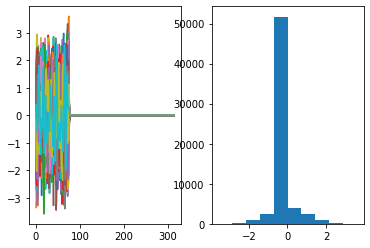

In [8]:
N = raw_data.shape[0]
idx = random.randint(0, N)
print('plotting %d subj with total number of subjects (%d)'%(idx, N))
plt.subplot(1, 2, 1)
plt.plot(raw_data[idx])
plt.subplot(1, 2, 2)
plt.hist(raw_data[idx].reshape(-1, 1))
plt.show()

# check the distribution of values

(array([6.0000000e+00, 2.1600000e+02, 6.4370000e+03, 3.8714400e+05,
        9.1904640e+06, 5.0349324e+07, 6.4542380e+06, 2.0031100e+05,
        2.7900000e+03, 7.0000000e+01]),
 array([-9.1124198 , -7.43200219, -5.75158458, -4.07116698, -2.39074937,
        -0.71033176,  0.97008585,  2.65050346,  4.33092107,  6.01133867,
         7.69175628]),
 <a list of 10 Patch objects>)

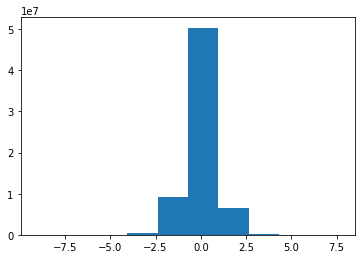

In [9]:
plt.hist(raw_data.reshape(-1, 1))

# check the distribution of the length of scans

(array([ 25.,   0.,   0., 148.,   0.,  88.,  48.,   0., 200., 156.,  37.,
          0.,   1., 135.,  64.,   0.,   0.,   0., 142.,  13.]),
 array([ 77. ,  88.9, 100.8, 112.7, 124.6, 136.5, 148.4, 160.3, 172.2,
        184.1, 196. , 207.9, 219.8, 231.7, 243.6, 255.5, 267.4, 279.3,
        291.2, 303.1, 315. ]),
 <a list of 20 Patch objects>)

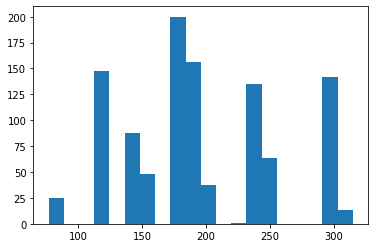

In [10]:
plt.hist(length.values(), bins=20)

# output data - leave one site out

In [ ]:
N_allVal = 0
with h5py.File(dataset_name, 'a') as f:
    for leftSite in sites:
        print('leave site out:', leftSite)
        train_idx = []
        val_idx = []
        for i, subj in enumerate(subjs):
            if dic[subj[2:]]['site'] == leftSite:
                val_idx.append(i)
            else:
                train_idx.append(i)
        assert len(val_idx) + len(train_idx) == len(subjs)
        N_allVal += len(val_idx)
        print('No. of subjs in %s: %d'%(leftSite, len(val_idx)))
        f.create_group(leftSite)    
        x_train, y_train = raw_data[train_idx], label[train_idx]
        x_val, y_val = raw_data[val_idx], label[val_idx]   
        f[leftSite].create_dataset('x_train', data=x_train)
        f[leftSite].create_dataset('y_train', data=y_train) 
        f[leftSite].create_dataset('x_val', data=x_val)
        f[leftSite].create_dataset('y_val', data=y_val)
print('all subjs taken as Val dataset: ', N_allVal)
assert N_allVal == len(subjs)

In [ ]:
N_allVal = 0
with h5py.File(dataset_name, 'r') as f:
    for leftSite in sites:
        x_train = f[leftSite]['x_train'][()]
        y_train = f[leftSite]['y_train'][()]
        x_val = f[leftSite]['x_val'][()]
        y_val = f[leftSite]['y_val'][()]
        assert x_train.shape[0] == y_train.shape[0]
        assert x_val.shape[0] == y_val.shape[0]
        assert x_train.shape[0] + x_val.shape[0] == len(subjs)
        assert y_train.shape[0] + y_val.shape[0] == len(subjs)
        N_allVal += x_val.shape[0]
print('all subjs taken as Val dataset: ', N_allVal)
assert N_allVal == len(subjs)

# check if subjs from Val in Training

In [ ]:
N_check = 0
with h5py.File(dataset_name, 'r') as f:
    for leftSite in sites:
        print('checking site:', leftSite)
        x_train = f[leftSite]['x_train'][()]
        x_val = f[leftSite]['x_val'][()]
        for iVal in range(x_val.shape[0]):
            N_check += 1
            for iTrain in range(x_train.shape[0]):
                assert not np.allclose(x_val[iVal], x_train[iTrain])
assert N_check == len(subjs)                
print('check subjs as val: ', N_check)

# check data unbalance

In [9]:
N_total = 0
N_label1 = 0
with h5py.File(dataset_name, 'r') as f:
    for leftSite in sorted(sites):
        print('site:', leftSite)
        y_val = f[leftSite]['y_val'][()]
        N_total += y_val.shape[0]
        N_label1 += np.sum(y_val)
        print('\ttotal data: %d, label=1: %d'%(y_val.shape[0], np.sum(y_val)))
print('total subjs: %d, total label = 1: %d'%(N_total, N_label1))

site: CALTECH
	total data: 38, label=1: 19
site: CMU
	total data: 27, label=1: 13
site: KKI
	total data: 55, label=1: 33
site: LEUVEN
	total data: 64, label=1: 35
site: MAX_MUN
	total data: 54, label=1: 32
site: NYU
	total data: 148, label=1: 69
site: OHSU
	total data: 25, label=1: 14
site: OLIN
	total data: 36, label=1: 16
site: PITT
	total data: 56, label=1: 27
site: SBL
	total data: 30, label=1: 15
site: SDSU
	total data: 35, label=1: 21
site: STANFORD
	total data: 39, label=1: 20
site: TRINITY
	total data: 49, label=1: 25
site: UCLA
	total data: 102, label=1: 46
site: UM
	total data: 142, label=1: 76
site: USM
	total data: 101, label=1: 43
site: YALE
	total data: 56, label=1: 28
total subjs: 1057, total label = 1: 532


# output data - 10 fold - stratified based on no. of subjs in each site and the portions of ASD in each site

In [6]:
dataset_name = 'abide_I_10_fold_self_preprocessing_CC200_filter_0.1_0.01_norm_demean.h5'

In [14]:
site_idx_label = {site: [] for site in sites}
totol_N = 0
setIdx = set()
for idx in range(len(subjs)):
    site_idx_label[subjs_site[idx]].append([idx, label[idx]])
for site in site_idx_label:
    site_idx_label[site] = np.array(site_idx_label[site])
    totol_N += site_idx_label[site].shape[0]
    setIdx.update(set(site_idx_label[site][:, 0]))
assert totol_N == len(subjs)
assert len(setIdx) == len(subjs)

print('No. of label==1:')
for site in sorted(sites):
    print(site, ':', np.sum(site_idx_label[site], 0)[1])

No. of label==1:
CALTECH : 19
CMU : 13
KKI : 33
LEUVEN : 35
MAX_MUN : 32
NYU : 69
OHSU : 14
OLIN : 16
PITT : 27
SBL : 15
SDSU : 21
STANFORD : 20
TRINITY : 25
UCLA : 46
UM : 76
USM : 43
YALE : 28


<Figure size 720x360 with 0 Axes>

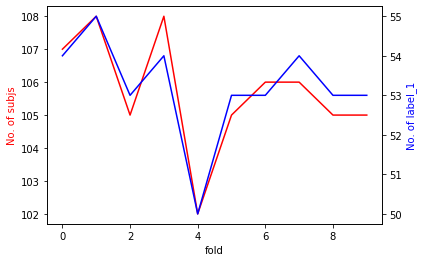

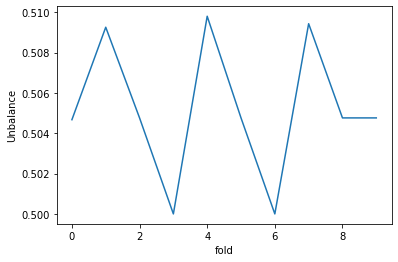

In [132]:
fold = 10
site_idx_stratified_k_fold = {site: [] for site in sites}
skf = StratifiedKFold(n_splits=fold, shuffle=True)
for site in sites:
    for i, (_, val_index) in enumerate(skf.split(site_idx_label[site][:, [0]], site_idx_label[site][:, [1]])):
        site_idx_stratified_k_fold[site].append(list(site_idx_label[site][val_index, 0]))
setIdx = set()
for site in sites:
    for i in range(fold):
        setIdx.update(set(site_idx_stratified_k_fold[site][i]))
assert len(setIdx) == len(subjs)

# because the last fold in each site has the smallest, so shuffle each site
for site in sites:
    random.shuffle(site_idx_stratified_k_fold[site])
    
setIdx = set()
for site in sites:
    for i in range(fold):
        setIdx.update(set(site_idx_stratified_k_fold[site][i]))
assert len(setIdx) == len(subjs)

lengthFold = [0] * fold
labelOneFold = [0] * fold

for i in range(fold):
    for site in sites:
        lengthFold[i] += len(site_idx_stratified_k_fold[site][i])
        labelOneFold[i] += sum(label[site_idx_stratified_k_fold[site][i]])
        
unbalance = [0] * fold
for i in range(fold):
    tmp = labelOneFold[i] / lengthFold[i]
    unbalance[i] = max(tmp, 1 - tmp)
    
final_idx_on_raw_data = [[] for _ in range(fold)]
check_labelOneFold = [0] * fold
for fold_i in range(fold):
    for site in sites:
        final_idx_on_raw_data[fold_i] += site_idx_stratified_k_fold[site][fold_i]
    check_labelOneFold[fold_i] = sum(label[final_idx_on_raw_data[fold_i]])
assert check_labelOneFold == labelOneFold

check_total_idx = set()
for fold_i in range(fold):
    check_total_idx.update(set(final_idx_on_raw_data[fold_i]))
assert len(check_total_idx) == len(subjs)
        

plt.figure(figsize=(10, 5))        
fig, ax1 = plt.subplots()
color1 = 'red'
ax1.plot(lengthFold, color=color1)
ax1.set_ylabel('No. of subjs', color=color1)
ax1.set_xlabel('fold')

color2 = 'blue'
ax2 = ax1.twinx()
ax2.plot(labelOneFold, color=color2)
ax2.set_ylabel('No. of label_1', color=color2)

plt.subplots()
plt.plot(unbalance)
plt.xlabel('fold')
plt.ylabel('Unbalance')
plt.show()

In [133]:
with h5py.File(dataset_name, 'a') as f:
    for fold_i in range(fold):
        f.create_group(str(fold_i))
        f[str(fold_i)].create_dataset('X', data=raw_data[final_idx_on_raw_data[fold_i]])
        f[str(fold_i)].create_dataset('Y', data=label[final_idx_on_raw_data[fold_i]])

# fold unbalance

[0.5046728971962616, 0.5092592592592593, 0.5047619047619047, 0.5, 0.5098039215686274, 0.5047619047619047, 0.5, 0.5094339622641509, 0.5047619047619047, 0.5047619047619047]


<Figure size 720x360 with 0 Axes>

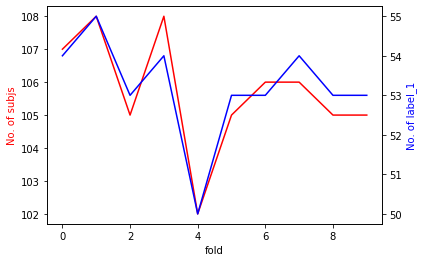

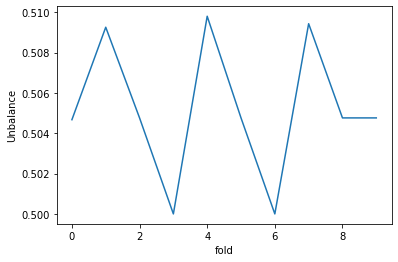

In [7]:
N_fold = [0] * fold
N_label_1 = [0] * fold
with h5py.File(dataset_name, 'r') as f:
    for fold_i in range(fold):
        N_fold[fold_i] += f[str(fold_i)]['X'][()].shape[0]
        N_label_1[fold_i] += sum(f[str(fold_i)]['Y'][()])

unbalance = [0] * fold
for i in range(fold):
    tmp = N_label_1[i] / N_fold[i]
    unbalance[i] = max(tmp, 1 - tmp)
print(unbalance)

plt.figure(figsize=(10, 5))        
fig, ax1 = plt.subplots()
color1 = 'red'
ax1.plot(N_fold, color=color1)
ax1.set_ylabel('No. of subjs', color=color1)
ax1.set_xlabel('fold')

color2 = 'blue'
ax2 = ax1.twinx()
ax2.plot(N_label_1, color=color2)
ax2.set_ylabel('No. of label_1', color=color2)

plt.subplots()
plt.plot(unbalance)
plt.xlabel('fold')
plt.ylabel('Unbalance')
plt.show()